# Implementing Conditional GANs 

* The cleaned Fashion Product Images dataset is loaded and used to train the cGAN.

* An implementation of cGAN will be carried out using only one feature (subCategory) with 3 lables (Topwear, Watches, Shoes). 

### Step 1: Import the needed libraries 


In [1]:
from keras import backend as K
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import MaxPooling2D, UpSampling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import concatenate

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math   

from tqdm import tqdm
initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
%matplotlib inline

### Step 2: Data Loading
The data used in this notebook is the cleaned one with around 14000 images 

In [2]:
# load Fashion Product Images dataset
width=100
batch_size=100 # batch size of image generator = batch size of GAN
df_features=pd.read_csv('df_shoes.csv')
path = '/home/group6/G.Deep Learning/Project/Shoes-dataset'
    
Img_generator=ImageDataGenerator(rescale=1./255)
train_gen=Img_generator.flow_from_directory(path, classes=[''], target_size=(width,width),batch_size=batch_size,shuffle=False)

Found 28701 images belonging to 1 classes.


In [3]:
df_features.head()

CID Category SubCategory HeelHeight  Closure Gender Material  \
0  100627.255.jpg    Shoes       Flats       Flat  Lace up    Men  Leather   
1   100627.72.jpg    Shoes       Flats       Flat  Lace up    Men  Leather   
2  100657.216.jpg    Shoes       Flats       Flat  Lace up    Men  Leather   
3   100657.72.jpg    Shoes       Flats       Flat  Lace up    Men  Leather   
4    101026.3.jpg    Shoes       Boots        Low  Pull-on    Men  Leather   

     ToeStyle  
0   Round Toe  
1   Round Toe  
2   Round Toe  
3   Round Toe  
4  Closed Toe

Since we are dealing only with one feature (subCategory) with only three labels: (Topwear, Watches, Shoes) we will change the encoding of these labels to (0, 1, 2) respectivaly and use the coded classes as int labels in the following code.  

In [4]:
df_features['Gender'].unique()

array(['Men', 'Women'], dtype=object)

In [5]:
df_selected_features = pd.get_dummies(df_features['Gender'])
df_selected_features = df_selected_features.rename(columns = {'Men': 'l1', 'Women': 'l2'}, inplace = False)
df_selected_features['id'] = df_features['CID']
df_selected_features.head()

l1  l2              id
0   1   0  100627.255.jpg
1   1   0   100627.72.jpg
2   1   0  100657.216.jpg
3   1   0   100657.72.jpg
4   1   0    101026.3.jpg

In [6]:
img_size = (width, width, 3)
latent_size = 100
num_labels = 2
num_batches = math.floor(14409/batch_size)
num_batches

144

In [7]:
train_gen.filenames

['100627.255.jpg',
 '100627.72.jpg',
 '100657.216.jpg',
 '100657.72.jpg',
 '101026.3.jpg',
 '101178.238499.jpg',
 '101178.68022.jpg',
 '101182.3.jpg',
 '101182.381.jpg',
 '101186.3.jpg',
 '101191.20.jpg',
 '101191.238499.jpg',
 '101191.239309.jpg',
 '101191.239312.jpg',
 '101191.3.jpg',
 '101191.598.jpg',
 '101191.65553.jpg',
 '101191.81355.jpg',
 '101192.665.jpg',
 '101430.106.jpg',
 '101430.231.jpg',
 '101430.352.jpg',
 '101430.594.jpg',
 '101430.691.jpg',
 '101430.84351.jpg',
 '101434.299742.jpg',
 '101434.299743.jpg',
 '101434.299744.jpg',
 '103888.609.jpg',
 '103888.72.jpg',
 '103900.1201.jpg',
 '103902.27143.jpg',
 '104002.1257.jpg',
 '104002.3.jpg',
 '104010.1267.jpg',
 '104011.1269.jpg',
 '104011.1270.jpg',
 '104018.1277.jpg',
 '104025.1285.jpg',
 '104025.1286.jpg',
 '104027.1285.jpg',
 '104035.1292.jpg',
 '104035.1293.jpg',
 '104038.1288.jpg',
 '104670.1611.jpg',
 '104670.1626.jpg',
 '104670.3.jpg',
 '104705.130551.jpg',
 '104705.15.jpg',
 '104705.72.jpg',
 '104708.3.jpg',
 '1

### Step 3: cGAN Implementation
Using only one feature (subCategory) with 3 lables (Topwear, Watches, Shoes). 
The origional code can be found [here](https://www.kaggle.com/bothmena/conditional-gan-keras-implementation)

### Generator 

In [8]:
def build_generator(inputs, labels, image_size):
    """Build a Generator Model
    Inputs are concatenated before Dense layer.
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.
    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)
    Returns:
        generator (Model): Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 3]

    # simply concatenate the one-hot-encoded label with the
    # inputs. axis = 1
    x = concatenate([inputs, labels], axis=1)
    
    # note that the starting size did not change, just the input size x.
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    generator.summary()
    return generator

### Discriminator

In [9]:
def build_discriminator(inputs, labels, image_size):
    """Build a Discriminator Model
    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.
    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)
    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256, 512]

    x = inputs
    y = Dense(image_size * image_size * 3)(labels)
    y = Reshape((image_size, image_size, 3))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    discriminator.summary()
    return discriminator

### Building the model

In [10]:
# img_size=(100,100,3)
# width=100

lables_shape = (num_labels, )

labels = Input(shape=lables_shape, name='labels')
inputs = Input(shape=img_size, name='image')

disc = build_discriminator(inputs, labels, width)
disc.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.0002, beta_1=0.5), 
                      metrics=['accuracy']) 


z_inputs = (latent_size, )
z_inputs = Input(shape=z_inputs, name='noise')
gen = build_generator(z_inputs, labels, width)

z = Input(shape=(latent_size,))
label = Input(shape=(num_labels,))

img = gen([z, label])
prediction = disc([img, label])

# Conditional (Conditional) GAN model with fixed discriminator to train the generator
cgan = Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.0002, beta_1=0.5), 
                      metrics=['accuracy']) 

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
labels (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30000)        90000       labels[0][0]                     
__________________________________________________________________________________________________
image (InputLayer)              [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 100, 3)  0           dense[0][0]                      
______________________________________________________________________________________

### Outputting sample images

In [11]:
np.eye(num_labels)


array([[1., 0.],
       [0., 1.]])

In [12]:
# predict 10 images
def plot_images(generator,
                noise_input,
                show=False,
                file_name="images/cGAN/Latent100/Epoch_1.png"):
    z = np.random.normal(0, 1, size=(10, latent_size))
    noise_class = np.eye(num_labels)[np.random.choice(num_labels, 10)]
    gen_imgs = generator.predict([z, noise_class])
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(gen_imgs[i].reshape(100, 100, 3)) #Draw the first 10 img in the first batch
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig(file_name)    
    plt.show()

### Training

In [13]:
f = df_selected_features.loc[:, df_selected_features.columns != 'id'].to_numpy()
f

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [14]:
accuracies = []
losses = []
def train(train_gen, y_train, epochs, generator_batch_size, sample_interval=1, ite_to_save=100):
    
    real = np.ones(shape=(generator_batch_size, 1))
    fake = np.zeros(shape=(generator_batch_size, 1))
    
    for epoch in tqdm(range(epochs)):
        train_gen.reset() #To insure that we start again from the same batch (0)
        for batch in range(num_batches):
            #load current batch
            x_train = train_gen.next()
            train_size=(x_train[0].shape)[0] #the same as the origional batch size = 100
            batch_size=train_size
            
            # extracting ids of current batch
            idx = (train_gen.batch_index - 1) * generator_batch_size  
            ids_currentBatch=train_gen.filenames[idx : idx + (batch_size)]  
            
            ids_currentBatch=[s.replace('images/', '') for s in ids_currentBatch] # extract image id 
            ids_currentBatch=np.array(ids_currentBatch)
            if(epoch == 0 and batch==0): #Debugging
                print(ids_currentBatch)
                
            real_images=x_train[0][0:batch_size]   
            
            # get corresponding full features 
            df_features_currentBatch=y_train.loc[y_train['id'].isin(ids_currentBatch)]
            
#             labels = df_features_currentBatch['subCategory'] #The labels here are 0, 1 and 2
            #Select all the labels execpt the id
            labels = df_features_currentBatch.loc[:, df_features_currentBatch.columns != 'id'].to_numpy()
    
            z = np.random.normal(0, 1, size=(batch_size, latent_size))
            gen_imgs = gen.predict([z, labels])
        
            d_loss_real = disc.train_on_batch([real_images, labels], real)
            d_loss_fake = disc.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
            z = np.random.normal(0, 1, size=(batch_size, latent_size))
            labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        
            g_loss = cgan.train_on_batch([z, labels], real)
            
#         if epoch % sample_interval == 0:
        print('{} [D loss: {}, accuracy: {:.2f}] [G loss: {}, G accuracy: {:.2f}]'.format(epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1]))
        
        losses.append((d_loss[0], g_loss))
        accuracies.append(d_loss[1])
            
        if epoch % ite_to_save == 0:    
            plot_images(gen,
                z,
                show=True,
                file_name="images/cGAN/Latent100/Epoch_{}.png".format(epoch))
            disc.save('cGANModels/Latent100/dcdisc_{}.h5'.format(epoch))  
            gen.save('cGANModels/Latent100/dcgen_{}.h5'.format(epoch))  
            cgan.save('cGANModels/Latent100/dcGAN_{}.h5'.format(epoch))     
    

### Start Training 

  0%|          | 0/201 [00:00<?, ?it/s]

['100627.255.jpg' '100627.72.jpg' '100657.216.jpg' '100657.72.jpg'
 '101026.3.jpg' '101178.238499.jpg' '101178.68022.jpg' '101182.3.jpg'
 '101182.381.jpg' '101186.3.jpg' '101191.20.jpg' '101191.238499.jpg'
 '101191.239309.jpg' '101191.239312.jpg' '101191.3.jpg' '101191.598.jpg'
 '101191.65553.jpg' '101191.81355.jpg' '101192.665.jpg' '101430.106.jpg'
 '101430.231.jpg' '101430.352.jpg' '101430.594.jpg' '101430.691.jpg'
 '101430.84351.jpg' '101434.299742.jpg' '101434.299743.jpg'
 '101434.299744.jpg' '103888.609.jpg' '103888.72.jpg' '103900.1201.jpg'
 '103902.27143.jpg' '104002.1257.jpg' '104002.3.jpg' '104010.1267.jpg'
 '104011.1269.jpg' '104011.1270.jpg' '104018.1277.jpg' '104025.1285.jpg'
 '104025.1286.jpg' '104027.1285.jpg' '104035.1292.jpg' '104035.1293.jpg'
 '104038.1288.jpg' '104670.1611.jpg' '104670.1626.jpg' '104670.3.jpg'
 '104705.130551.jpg' '104705.15.jpg' '104705.72.jpg' '104708.3.jpg'
 '104710.3.jpg' '104712.215.jpg' '104712.835.jpg' '104717.15.jpg'
 '104717.72.jpg' '104719.1

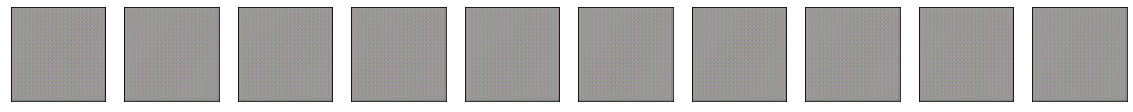

  1%|          | 2/201 [02:12<3:34:52, 64.79s/it]

1 [D loss: 0.0001289693166795225, accuracy: 100.00] [G loss: 2.7012699774786597e-06, G accuracy: 100.00]


  1%|▏         | 3/201 [03:10<3:24:37, 62.01s/it]

2 [D loss: 8.402787310139714e-05, accuracy: 100.00] [G loss: 2.3822833554731915e-06, G accuracy: 100.00]


  2%|▏         | 4/201 [04:09<3:19:37, 60.80s/it]

3 [D loss: 0.017586783040314913, accuracy: 100.00] [G loss: 0.009523008018732071, G accuracy: 100.00]


  2%|▏         | 5/201 [05:08<3:16:12, 60.06s/it]

4 [D loss: 0.00039964883082532765, accuracy: 100.00] [G loss: 0.0007545626722276211, G accuracy: 100.00]
5 [D loss: 1.4784050520140113, accuracy: 60.50] [G loss: 7.933216571807861, G accuracy: 0.00]


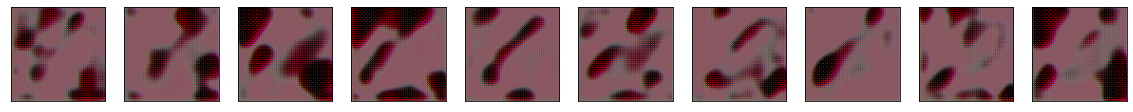

  3%|▎         | 7/201 [07:06<3:12:07, 59.42s/it]

6 [D loss: 0.0065915900049731135, accuracy: 100.00] [G loss: 0.00027509976644068956, G accuracy: 100.00]


  4%|▍         | 8/201 [08:05<3:10:42, 59.29s/it]

7 [D loss: 0.002200528119203682, accuracy: 100.00] [G loss: 0.03349991515278816, G accuracy: 99.00]


  4%|▍         | 9/201 [09:03<3:08:50, 59.01s/it]

8 [D loss: 0.0007700024861985177, accuracy: 100.00] [G loss: 0.0005905035650357604, G accuracy: 100.00]


  5%|▍         | 10/201 [10:02<3:07:17, 58.84s/it]

9 [D loss: 0.0003268067215493886, accuracy: 100.00] [G loss: 0.0007726596086286008, G accuracy: 100.00]
10 [D loss: 0.0010164952845973315, accuracy: 100.00] [G loss: 0.001049106358550489, G accuracy: 100.00]


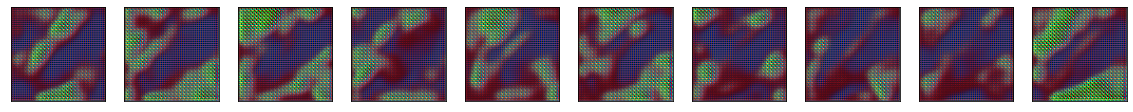

  6%|▌         | 12/201 [12:00<3:05:41, 58.95s/it]

11 [D loss: 8.995438575744629, accuracy: 50.00] [G loss: 3.5384910106658936, G accuracy: 0.00]


  6%|▋         | 13/201 [12:59<3:04:37, 58.92s/it]

12 [D loss: 0.00320666516199708, accuracy: 100.00] [G loss: 0.016705607995390892, G accuracy: 99.00]


  7%|▋         | 14/201 [13:58<3:03:40, 58.93s/it]

13 [D loss: 0.002094372197817041, accuracy: 100.00] [G loss: 0.004866838920861483, G accuracy: 100.00]


  7%|▋         | 15/201 [14:57<3:02:34, 58.90s/it]

14 [D loss: 0.0004167574229767627, accuracy: 100.00] [G loss: 1.1158515585596614e-14, G accuracy: 100.00]
15 [D loss: 0.0037478577833098825, accuracy: 100.00] [G loss: 0.004926809575408697, G accuracy: 100.00]


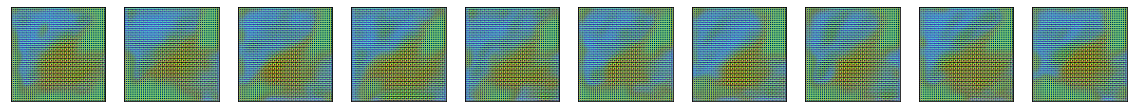

  8%|▊         | 17/201 [16:55<3:00:29, 58.85s/it]

16 [D loss: 0.0012295056993849585, accuracy: 100.00] [G loss: 4.511719934758847e-16, G accuracy: 100.00]


  9%|▉         | 18/201 [17:53<2:59:14, 58.77s/it]

17 [D loss: 0.00840737298130989, accuracy: 99.50] [G loss: 0.09379696100950241, G accuracy: 97.00]


  9%|▉         | 19/201 [18:52<2:57:55, 58.66s/it]

18 [D loss: 1.484992163958143e-11, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


 10%|▉         | 20/201 [19:50<2:56:38, 58.56s/it]

19 [D loss: 1.7468429416439557e-06, accuracy: 100.00] [G loss: 5.092303467790771e-08, G accuracy: 100.00]
20 [D loss: 0.0001388628184031404, accuracy: 100.00] [G loss: 1.9418645536006807e-07, G accuracy: 100.00]


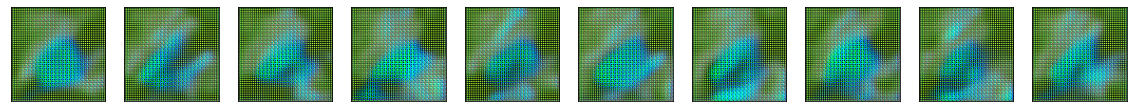

 11%|█         | 22/201 [21:48<2:55:23, 58.79s/it]

21 [D loss: 0.0005871717585250741, accuracy: 100.00] [G loss: 1.7087671687403525e-18, G accuracy: 100.00]


 11%|█▏        | 23/201 [22:47<2:54:47, 58.92s/it]

22 [D loss: 71.99040222167969, accuracy: 50.00] [G loss: 0.0001031875581247732, G accuracy: 100.00]


 12%|█▏        | 24/201 [23:45<2:53:10, 58.70s/it]

23 [D loss: 0.0002811299347569464, accuracy: 100.00] [G loss: 2.4268703782581724e-05, G accuracy: 100.00]


 12%|█▏        | 25/201 [24:44<2:52:11, 58.70s/it]

24 [D loss: 1.57072445290396e-05, accuracy: 100.00] [G loss: 0.0003305031859781593, G accuracy: 100.00]
25 [D loss: 0.00023062538884932593, accuracy: 100.00] [G loss: 3.8372957078536274e-07, G accuracy: 100.00]


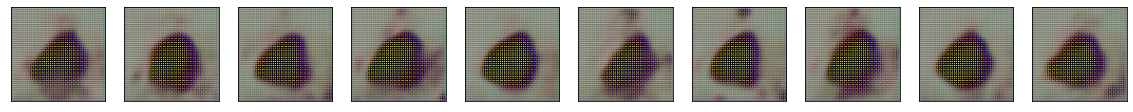

 13%|█▎        | 27/201 [26:42<2:50:32, 58.81s/it]

26 [D loss: 4.4822837108604574e-10, accuracy: 100.00] [G loss: 1.0271283419623508e-20, G accuracy: 100.00]


 14%|█▍        | 28/201 [27:41<2:49:30, 58.79s/it]

27 [D loss: 0.015689050778746605, accuracy: 99.50] [G loss: 1.0053259336118003e-09, G accuracy: 100.00]


 14%|█▍        | 29/201 [28:39<2:48:13, 58.69s/it]

28 [D loss: 0.0032539782114332817, accuracy: 100.00] [G loss: 0.013271348550915718, G accuracy: 100.00]


 15%|█▍        | 30/201 [29:38<2:47:02, 58.61s/it]

29 [D loss: 1.037578476825729e-05, accuracy: 100.00] [G loss: 2.4320287040682303e-28, G accuracy: 100.00]
30 [D loss: 1.112833913907707e-07, accuracy: 100.00] [G loss: 1.6774787354734144e-06, G accuracy: 100.00]


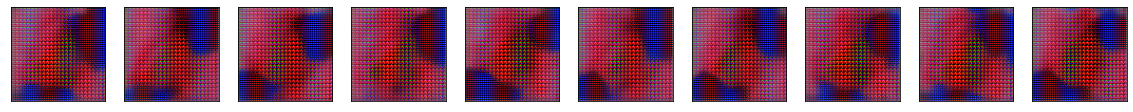

 16%|█▌        | 32/201 [31:36<2:45:49, 58.87s/it]

31 [D loss: 0.004776570945980277, accuracy: 100.00] [G loss: 7.345818042755127, G accuracy: 0.00]


 16%|█▋        | 33/201 [32:35<2:44:51, 58.88s/it]

32 [D loss: 0.002198722448284787, accuracy: 100.00] [G loss: 0.0035639789421111345, G accuracy: 100.00]


 17%|█▋        | 34/201 [33:34<2:43:43, 58.82s/it]

33 [D loss: 2.2765800952911377, accuracy: 53.50] [G loss: 121.8875961303711, G accuracy: 0.00]


 17%|█▋        | 35/201 [34:32<2:42:16, 58.66s/it]

34 [D loss: 9.065084493133698e-05, accuracy: 100.00] [G loss: 1.0163850751336299e-16, G accuracy: 100.00]
35 [D loss: 0.00018720847130550993, accuracy: 100.00] [G loss: 1.2133322971549328e-34, G accuracy: 100.00]


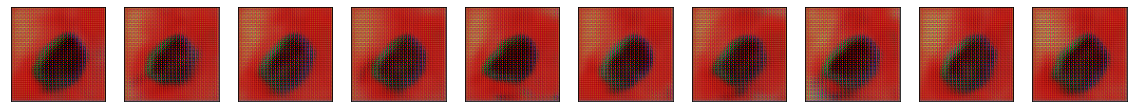

 18%|█▊        | 37/201 [36:30<2:40:37, 58.76s/it]

36 [D loss: 0.0020271455869087596, accuracy: 100.00] [G loss: 2.368824544759703e-21, G accuracy: 100.00]


 19%|█▉        | 38/201 [37:28<2:39:23, 58.67s/it]

37 [D loss: 0.010413222968639335, accuracy: 99.50] [G loss: 0.0026355457957834005, G accuracy: 100.00]


 19%|█▉        | 39/201 [38:26<2:38:06, 58.56s/it]

38 [D loss: 0.019939672201871872, accuracy: 99.50] [G loss: 0.0040176017209887505, G accuracy: 100.00]


 20%|█▉        | 40/201 [39:25<2:37:09, 58.57s/it]

39 [D loss: 0.001348336460068822, accuracy: 100.00] [G loss: 0.006235464941710234, G accuracy: 100.00]
40 [D loss: 0.5072507262229919, accuracy: 98.00] [G loss: 8.628759132989217e-06, G accuracy: 100.00]


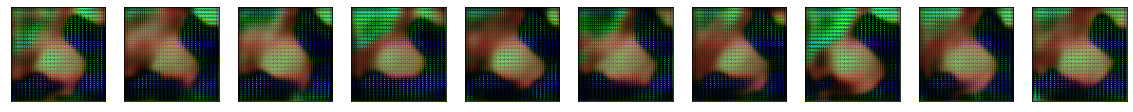

 21%|██        | 42/201 [41:23<2:35:33, 58.70s/it]

41 [D loss: 8.801930739821273e-09, accuracy: 100.00] [G loss: 0.08616913855075836, G accuracy: 99.00]


 21%|██▏       | 43/201 [42:22<2:34:39, 58.73s/it]

42 [D loss: 0.018736131489276886, accuracy: 99.50] [G loss: 12.034018516540527, G accuracy: 50.00]


 22%|██▏       | 44/201 [43:21<2:33:49, 58.79s/it]

43 [D loss: 0.0002937784011938946, accuracy: 100.00] [G loss: 2.7688542104442604e-05, G accuracy: 100.00]


 22%|██▏       | 45/201 [44:19<2:32:27, 58.64s/it]

44 [D loss: 1.0842690244317055e-05, accuracy: 100.00] [G loss: 1.1476159122538027e-24, G accuracy: 100.00]
45 [D loss: 2.1148809092874643e-10, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


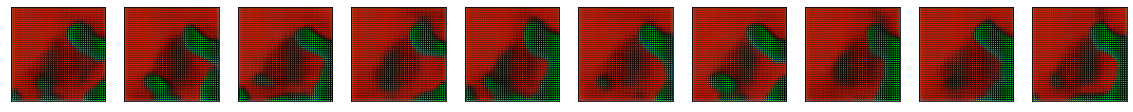

 23%|██▎       | 47/201 [46:16<2:30:23, 58.59s/it]

46 [D loss: 0.0007994623738341033, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


 24%|██▍       | 48/201 [47:15<2:29:33, 58.65s/it]

47 [D loss: 7.939393520355225, accuracy: 65.50] [G loss: 216.91334533691406, G accuracy: 0.00]


 24%|██▍       | 49/201 [48:13<2:28:32, 58.64s/it]

48 [D loss: 7.147034867216462e-05, accuracy: 100.00] [G loss: 1.8778144458223706e-13, G accuracy: 100.00]


 25%|██▍       | 50/201 [49:12<2:27:32, 58.63s/it]

49 [D loss: 18.797748565673828, accuracy: 50.00] [G loss: 60.201839447021484, G accuracy: 0.00]
50 [D loss: 2.348777962879467e-05, accuracy: 100.00] [G loss: 0.00018730427836999297, G accuracy: 100.00]


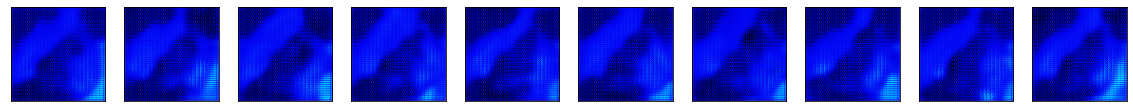

 26%|██▌       | 52/201 [51:10<2:25:52, 58.74s/it]

51 [D loss: 0.022415373474359786, accuracy: 99.50] [G loss: 0.0, G accuracy: 100.00]


 26%|██▋       | 53/201 [52:08<2:24:36, 58.63s/it]

52 [D loss: 6.374593795044348e-07, accuracy: 100.00] [G loss: 0.0010148982983082533, G accuracy: 100.00]


 27%|██▋       | 54/201 [53:06<2:23:20, 58.50s/it]

53 [D loss: 4.463940786081366e-05, accuracy: 100.00] [G loss: 1.8364503906524937e-22, G accuracy: 100.00]


 27%|██▋       | 55/201 [54:05<2:22:33, 58.58s/it]

54 [D loss: 0.00026986614102497697, accuracy: 100.00] [G loss: 0.0091025959700346, G accuracy: 99.00]
55 [D loss: 0.0006361334817484021, accuracy: 100.00] [G loss: 0.0030789596494287252, G accuracy: 100.00]


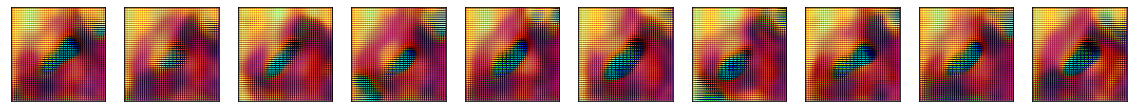

 28%|██▊       | 57/201 [56:03<2:20:43, 58.64s/it]

56 [D loss: 9.345970852234209e-05, accuracy: 100.00] [G loss: 0.00024190996191464365, G accuracy: 100.00]


 29%|██▉       | 58/201 [57:01<2:19:30, 58.53s/it]

57 [D loss: 0.0015474194660782814, accuracy: 100.00] [G loss: 0.0001976272469619289, G accuracy: 100.00]


 29%|██▉       | 59/201 [58:00<2:18:24, 58.48s/it]

58 [D loss: 0.0003062787582166493, accuracy: 100.00] [G loss: 1.5575141003310033e-12, G accuracy: 100.00]


 30%|██▉       | 60/201 [58:58<2:17:42, 58.60s/it]

59 [D loss: 0.0001376835280098021, accuracy: 100.00] [G loss: 1.0915013337609025e-09, G accuracy: 100.00]
60 [D loss: 7.8390412330753945, accuracy: 50.00] [G loss: 2.496281147003174, G accuracy: 38.00]


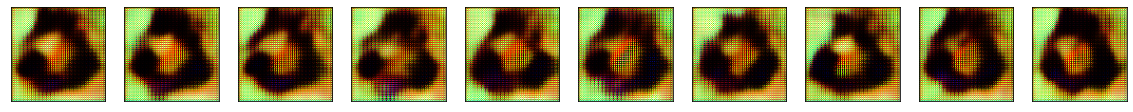

 31%|███       | 62/201 [1:00:57<2:16:20, 58.85s/it]

61 [D loss: 28.467296600341797, accuracy: 50.00] [G loss: 47.83844757080078, G accuracy: 0.00]


 31%|███▏      | 63/201 [1:01:55<2:15:11, 58.78s/it]

62 [D loss: 4.607126356859226e-06, accuracy: 100.00] [G loss: 0.0005680974572896957, G accuracy: 100.00]


 32%|███▏      | 64/201 [1:02:54<2:14:08, 58.75s/it]

63 [D loss: 0.002001834334805608, accuracy: 100.00] [G loss: 0.004973805509507656, G accuracy: 100.00]


 32%|███▏      | 65/201 [1:03:53<2:13:17, 58.80s/it]

64 [D loss: 0.0005239975289441645, accuracy: 100.00] [G loss: 0.003633302403613925, G accuracy: 100.00]
65 [D loss: 8.698989294064654e-24, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


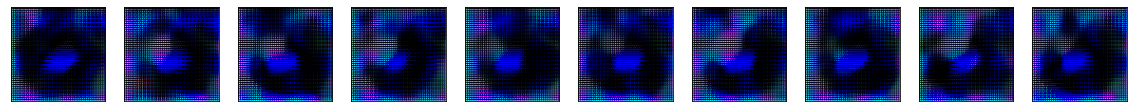

 33%|███▎      | 67/201 [1:05:50<2:11:04, 58.69s/it]

66 [D loss: 4.4762491597793996e-05, accuracy: 100.00] [G loss: 8.060343299927386e-13, G accuracy: 100.00]


 34%|███▍      | 68/201 [1:06:49<2:10:21, 58.81s/it]

67 [D loss: 5.731435332977943e-10, accuracy: 100.00] [G loss: 3.956518930292784e-20, G accuracy: 100.00]


 34%|███▍      | 69/201 [1:07:48<2:09:12, 58.73s/it]

68 [D loss: 2.530413621570915e-05, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


 35%|███▍      | 70/201 [1:08:46<2:07:50, 58.55s/it]

69 [D loss: 0.0, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]
70 [D loss: 0.02334642969071865, accuracy: 99.50] [G loss: 2.900968354424549e-08, G accuracy: 100.00]


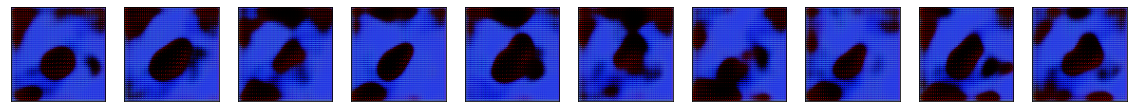

 36%|███▌      | 72/201 [1:10:44<2:06:11, 58.69s/it]

71 [D loss: 9.153749806756284e-12, accuracy: 100.00] [G loss: 1.032802288136736e-09, G accuracy: 100.00]


 36%|███▋      | 73/201 [1:11:42<2:05:04, 58.63s/it]

72 [D loss: 0.10670165717601776, accuracy: 99.50] [G loss: 1.3762690986851567e-09, G accuracy: 100.00]


 37%|███▋      | 74/201 [1:12:41<2:03:53, 58.53s/it]

73 [D loss: 0.08366516277777908, accuracy: 99.50] [G loss: 1.7790745806407246e-22, G accuracy: 100.00]


 37%|███▋      | 75/201 [1:13:39<2:02:44, 58.45s/it]

74 [D loss: 5.705856437998591e-06, accuracy: 100.00] [G loss: 1.4891372857039897e-10, G accuracy: 100.00]
75 [D loss: 2.7080395221710205, accuracy: 76.00] [G loss: 44.15757369995117, G accuracy: 0.00]


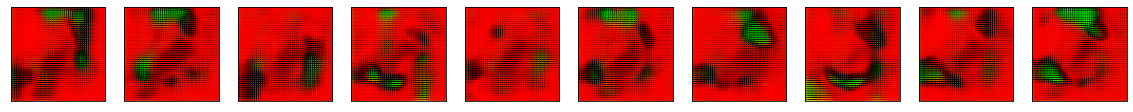

 38%|███▊      | 77/201 [1:15:37<2:01:21, 58.72s/it]

76 [D loss: 8.738940238952637, accuracy: 50.00] [G loss: 72.86168670654297, G accuracy: 0.00]


 39%|███▉      | 78/201 [1:16:36<2:00:27, 58.76s/it]

77 [D loss: 0.02490082010626793, accuracy: 98.50] [G loss: 0.07459098100662231, G accuracy: 98.00]


 39%|███▉      | 79/201 [1:17:34<1:59:18, 58.67s/it]

78 [D loss: 9.984339577329138e-09, accuracy: 100.00] [G loss: 0.167123943567276, G accuracy: 97.00]


 40%|███▉      | 80/201 [1:18:33<1:58:05, 58.56s/it]

79 [D loss: 0.0009851182112590058, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]
80 [D loss: 6.803910946473638e-05, accuracy: 100.00] [G loss: 3.873607452186583e-15, G accuracy: 100.00]


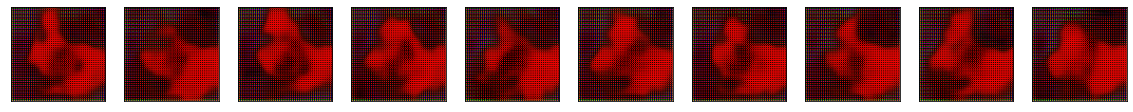

 41%|████      | 82/201 [1:20:31<1:56:30, 58.74s/it]

81 [D loss: 8.76289732332225e-07, accuracy: 100.00] [G loss: 1.5523862750832507e-10, G accuracy: 100.00]


 41%|████▏     | 83/201 [1:21:29<1:55:15, 58.60s/it]

82 [D loss: 8.504995889779821e-07, accuracy: 100.00] [G loss: 6.247605597309303e-07, G accuracy: 100.00]


 42%|████▏     | 84/201 [1:22:28<1:54:26, 58.69s/it]

83 [D loss: 0.00028643294353969395, accuracy: 100.00] [G loss: 0.0005252898554317653, G accuracy: 100.00]


 42%|████▏     | 85/201 [1:23:27<1:53:36, 58.76s/it]

84 [D loss: 0.0003114014398306608, accuracy: 100.00] [G loss: 8.154231181833893e-05, G accuracy: 100.00]
85 [D loss: 0.00022975729370955378, accuracy: 100.00] [G loss: 0.0005183139001019299, G accuracy: 100.00]


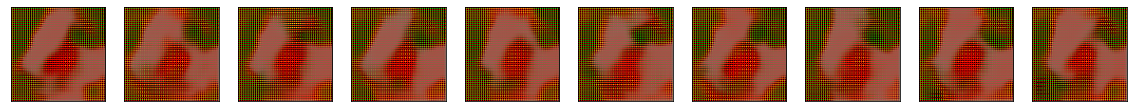

 43%|████▎     | 87/201 [1:25:25<1:52:03, 58.98s/it]

86 [D loss: 0.0005492567433975637, accuracy: 100.00] [G loss: 0.00024326835409738123, G accuracy: 100.00]


 44%|████▍     | 88/201 [1:26:24<1:50:59, 58.93s/it]

87 [D loss: 3.1568863079201037e-09, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


 44%|████▍     | 89/201 [1:27:22<1:49:47, 58.82s/it]

88 [D loss: 0.0006192715372890234, accuracy: 100.00] [G loss: 0.011907530017197132, G accuracy: 99.00]


 45%|████▍     | 90/201 [1:28:21<1:48:43, 58.77s/it]

89 [D loss: 0.0005712489946745336, accuracy: 100.00] [G loss: 11.782293319702148, G accuracy: 0.00]
90 [D loss: 152.91268920898438, accuracy: 50.00] [G loss: 2.116850097988454e-11, G accuracy: 100.00]


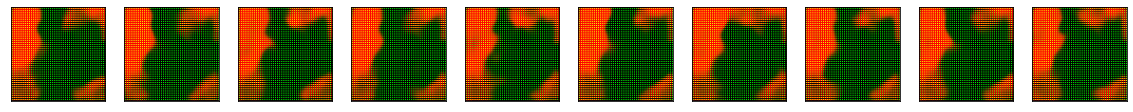

 46%|████▌     | 92/201 [1:30:20<1:47:13, 59.03s/it]

91 [D loss: 2.1767591817933862e-07, accuracy: 100.00] [G loss: 1.1054428620669552e-27, G accuracy: 100.00]


 46%|████▋     | 93/201 [1:31:18<1:45:57, 58.87s/it]

92 [D loss: 13.701415061950684, accuracy: 50.00] [G loss: 29.599279403686523, G accuracy: 0.00]


 47%|████▋     | 94/201 [1:32:17<1:45:06, 58.94s/it]

93 [D loss: 2.672545861059916e-06, accuracy: 100.00] [G loss: 0.01700729876756668, G accuracy: 99.00]


 47%|████▋     | 95/201 [1:33:16<1:43:55, 58.82s/it]

94 [D loss: 0.0003435914113651961, accuracy: 100.00] [G loss: 3.086013359908228e-21, G accuracy: 100.00]
95 [D loss: 9.351422424969255e-25, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


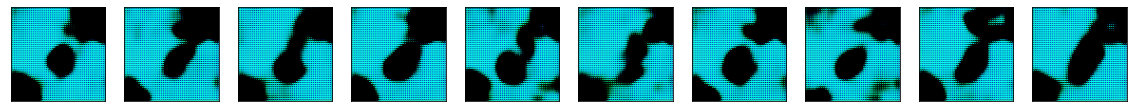

 48%|████▊     | 97/201 [1:35:13<1:41:52, 58.77s/it]

96 [D loss: 0.024262135848402977, accuracy: 99.00] [G loss: 1.6023115312960096e-20, G accuracy: 100.00]


 49%|████▉     | 98/201 [1:36:12<1:40:52, 58.77s/it]

97 [D loss: 0.011448643918811285, accuracy: 99.50] [G loss: 0.04804333299398422, G accuracy: 99.00]


 49%|████▉     | 99/201 [1:37:11<1:39:57, 58.79s/it]

98 [D loss: 2.883742654473764, accuracy: 88.00] [G loss: 3.7559422806003354e-17, G accuracy: 100.00]


 50%|████▉     | 100/201 [1:38:10<1:39:02, 58.84s/it]

99 [D loss: 0.008674711920320988, accuracy: 99.50] [G loss: 0.008131764829158783, G accuracy: 100.00]
100 [D loss: 0.18657846748828888, accuracy: 80.50] [G loss: 14.734100341796875, G accuracy: 0.00]


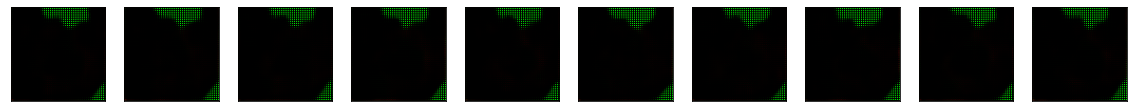

 51%|█████     | 102/201 [1:40:08<1:37:19, 58.98s/it]

101 [D loss: 0.0011358751216903329, accuracy: 100.00] [G loss: 11.934657096862793, G accuracy: 0.00]


 51%|█████     | 103/201 [1:41:07<1:36:16, 58.94s/it]

102 [D loss: 4.824705600738525, accuracy: 50.00] [G loss: 17.246305465698242, G accuracy: 0.00]


 52%|█████▏    | 104/201 [1:42:06<1:35:12, 58.90s/it]

103 [D loss: 0.00014708573871757835, accuracy: 100.00] [G loss: 1.988013718801085e-05, G accuracy: 100.00]


 52%|█████▏    | 105/201 [1:43:05<1:34:15, 58.91s/it]

104 [D loss: 5.799076916446211e-06, accuracy: 100.00] [G loss: 20.864484786987305, G accuracy: 0.00]
105 [D loss: 0.0009667620179243386, accuracy: 100.00] [G loss: 1.1973356777161825e-06, G accuracy: 100.00]


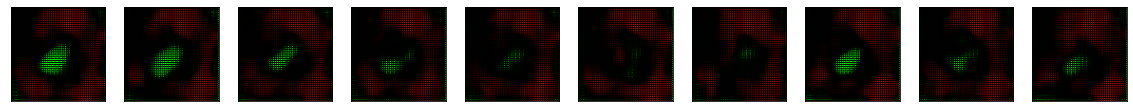

 53%|█████▎    | 107/201 [1:45:03<1:32:28, 59.03s/it]

106 [D loss: 0.005327506456524134, accuracy: 100.00] [G loss: 0.01003669947385788, G accuracy: 100.00]


 54%|█████▎    | 108/201 [1:46:02<1:31:13, 58.85s/it]

107 [D loss: 0.0003949752717744559, accuracy: 100.00] [G loss: 0.0003291791945230216, G accuracy: 100.00]


 54%|█████▍    | 109/201 [1:47:01<1:30:14, 58.85s/it]

108 [D loss: 2.7195804202378993e-12, accuracy: 100.00] [G loss: 0.0, G accuracy: 100.00]


 55%|█████▍    | 110/201 [1:47:59<1:29:06, 58.75s/it]

109 [D loss: 0.07408647425472736, accuracy: 99.00] [G loss: 0.0, G accuracy: 100.00]
110 [D loss: 2.0282860372538344e-15, accuracy: 100.00] [G loss: 4.0320127321201727e-22, G accuracy: 100.00]


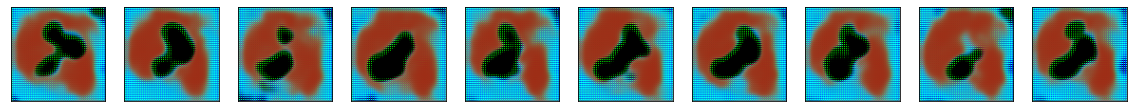

 56%|█████▌    | 112/201 [1:49:57<1:27:16, 58.84s/it]

111 [D loss: 5.773358603407779e-10, accuracy: 100.00] [G loss: 1.1695871157344664e-19, G accuracy: 100.00]


 56%|█████▌    | 113/201 [1:50:56<1:26:14, 58.80s/it]

112 [D loss: 0.02228531427681446, accuracy: 99.50] [G loss: 0.07183095067739487, G accuracy: 98.00]


 56%|█████▌    | 113/201 [1:51:18<1:26:41, 59.10s/it]


KeyboardInterrupt: 

In [15]:
epochs = 201
batch_size = 100
sample_interval = 1
ite_to_save = 5
# need to add these for the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

train(train_gen, df_selected_features, epochs, batch_size, sample_interval, ite_to_save)